<a href="https://colab.research.google.com/github/DanielCaputo111296/Diabete1/blob/Mitigation1/Copia_di_Diabete_FairLearn(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fairlearn
import pandas as pd
import numpy as np
from random import sample
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from fairlearn.metrics import demographic_parity_ratio
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from fairlearn.metrics import equalized_odds_difference
from fairlearn.metrics import demographic_parity_difference
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import f_oneway
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 34.0 MB/s 


In [2]:
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes.csv


In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['diabetes.csv']))

In [4]:
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


L'outcome indica se il paziente viene identificato come diabetico osservando le varie analisi o meno

# PRE-PROCESSING

Controlliamo prima di tutto la presenza di valori nulli

In [5]:
def check_null_value(array,name):
    p=array.isnull().sum()
    print("The number of missing value in "+name+" is "+ str(p))
    return p

In [6]:
preg_null=check_null_value(df["Pregnancies"],"Pregnancies")
gluc_null=check_null_value(df["Glucose"],"Glucose")
pres_null=check_null_value(df["BloodPressure"],"BloodPressure")
skin_null=check_null_value(df["SkinThickness"],"SkinThickness")
insu_null=check_null_value(df["Insulin"],"Insulin")
bmi_null=check_null_value(df["BMI"],"BMI")
diab_null=check_null_value(df["DiabetesPedigreeFunction"],"DiabetesPedigreeFunction")
age_null=check_null_value(df["Age"],"Age")
out_null=check_null_value(df["Outcome"],"Outcome")

The number of missing value in Pregnancies is 0
The number of missing value in Glucose is 0
The number of missing value in BloodPressure is 0
The number of missing value in SkinThickness is 0
The number of missing value in Insulin is 0
The number of missing value in BMI is 0
The number of missing value in DiabetesPedigreeFunction is 0
The number of missing value in Age is 0
The number of missing value in Outcome is 0


Dal risultato emerge che non ci sono valori tutti, tuttavia proviamo a fare delle computazioni sulle distribuzioni, per vedere la presenza di outlier.

# INSULINE

Text(0.5, 0, 'Insulin mu/ml')

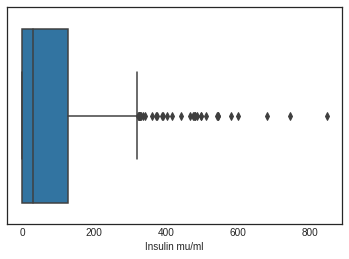

In [7]:
sns.boxplot(x=df["Insulin"])
plt.xlabel('Insulin mu/ml')

Vediamo di identificare gli outlier. Se un numero è inferiore a q1-1.5 * IQR o maggiore di Q3+1.5 * IQR allora è un valore anomalo.


Cominciamo a vedere di identificare gli outlier per l'insulina

In [8]:
def detect_outliers(column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3 - q1
    return df[column][(df[column] < (q1-1.5*IQR))|(df[column] > (q3 + 1.5*IQR))].tolist()
    

In [9]:
outlier_insulin=detect_outliers('Insulin')

Una volta individuati li sostituiamo con il valore della mediana

In [10]:
def replace_outlier_with_median(column,outliers):
    df[column] = np.where(df[column].isin(outliers),df[column].median(),df[column])
    return df[column]

In [11]:
df["Insulin"]=replace_outlier_with_median('Insulin',outlier_insulin)

Text(0.5, 0, 'Insulin mu/ml')

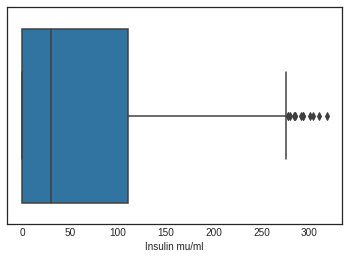

In [12]:
sns.boxplot(x=df["Insulin"])
plt.xlabel('Insulin mu/ml')

plottiamo la distribuzione dell'insulina

(array([418.,  56.,  74.,  62.,  50.,  45.,  27.,  14.,  15.,   7.]),
 array([  0. ,  31.8,  63.6,  95.4, 127.2, 159. , 190.8, 222.6, 254.4,
        286.2, 318. ]),
 <a list of 10 Patch objects>)

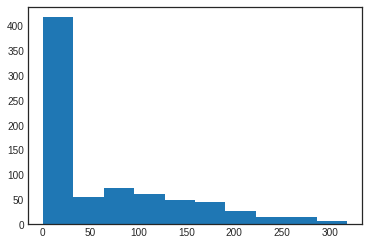

In [13]:
plt.hist(df["Insulin"])

In [14]:
df1=df[df["Insulin"]==0]
print(df1["Insulin"].value_counts())

0.0    374
Name: Insulin, dtype: int64


Ho trovato 374 valori di insulina a 0. Questi vengono intepretati come valori nulli, quindi li rimpiazzo con la mediana. 

In [15]:
df["Insulin"]=df["Insulin"].replace(0,df["Insulin"].median())

# GLUCOSE

Text(0.5, 0, 'Glucose 2 hour')

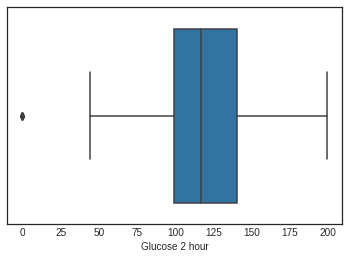

In [16]:
sns.boxplot(x=df["Glucose"])
plt.xlabel('Glucose 2 hour')

Dal grafico per quanto riguarda il glucosio non emergono particolari problemi

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

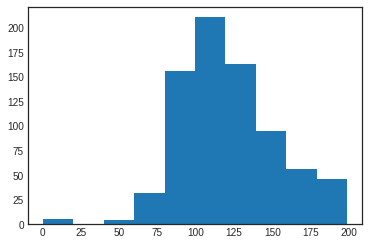

In [17]:
plt.hist(df["Glucose"])

In [18]:
df1=df[df["Glucose"]==0]
print(df1["Glucose"].value_counts())

0    5
Name: Glucose, dtype: int64


Essendoci solo 5 valori nulli, possiamo decidere se eliminarli oppure se rimpiazzarli con la mediana. In questo caso ho deciso di eliminarli

In [19]:
lista=df1["Glucose"].index
lista

Int64Index([75, 182, 342, 349, 502], dtype='int64')

In [20]:
df=df.drop(lista)

# BLOOD PRESSURE

Text(0.5, 0, 'Diastolic blood pressure (mm Hg) ')

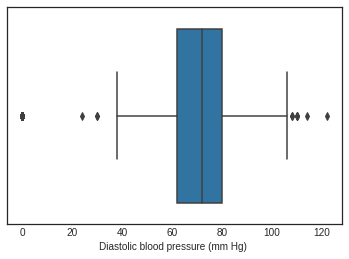

In [21]:
sns.boxplot(x=df["BloodPressure"])
plt.xlabel('Diastolic blood pressure (mm Hg) ')

Anche da questo grafico emergono la presenza di outlier. Anche per questi sostituiamo il valore della mediana

In [22]:
outlier_pressure=detect_outliers('BloodPressure')
df["BloodPressure"]=replace_outlier_with_median('BloodPressure',outlier_pressure)

Text(0.5, 0, 'Diastolic blood pressure (mm Hg) ')

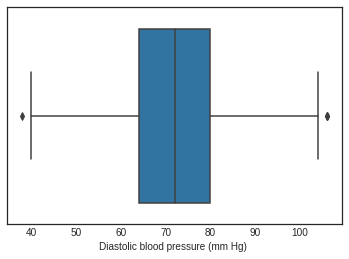

In [23]:
sns.boxplot(x=df["BloodPressure"])
plt.xlabel('Diastolic blood pressure (mm Hg) ')

(array([  6.,  19.,  57., 122., 130., 232.,  98.,  76.,  14.,   9.]),
 array([ 38. ,  44.8,  51.6,  58.4,  65.2,  72. ,  78.8,  85.6,  92.4,
         99.2, 106. ]),
 <a list of 10 Patch objects>)

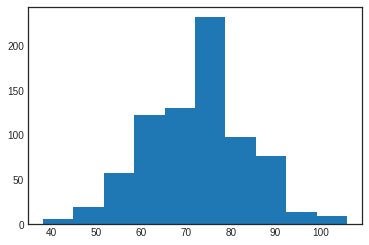

In [24]:
plt.hist(df["BloodPressure"])

# PREGNANCIES

Text(0.5, 0, ' Number of times pregnant ')

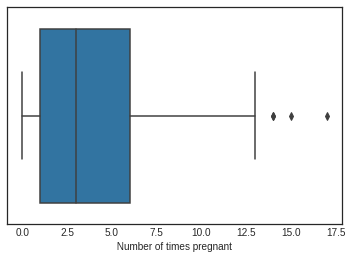

In [25]:
sns.boxplot(x=df["Pregnancies"])
plt.xlabel(' Number of times pregnant ')

Come notiamo qui effettivamente abbiamo degli outlier ben evidenti, e li rimuoviamo

In [26]:
outlier_preg=detect_outliers('Pregnancies')
df["Pregnancies"]=replace_outlier_with_median('Pregnancies',outlier_preg)

Text(0.5, 0, ' Number of times pregnant ')

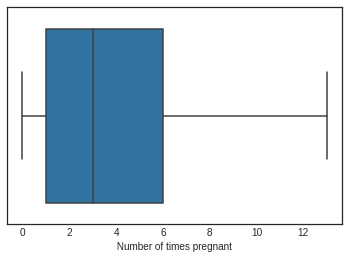

In [27]:
sns.boxplot(x=df["Pregnancies"])
plt.xlabel(' Number of times pregnant ')

(array([243., 103.,  79., 124.,  49.,  45.,  66.,  24.,  11.,  19.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <a list of 10 Patch objects>)

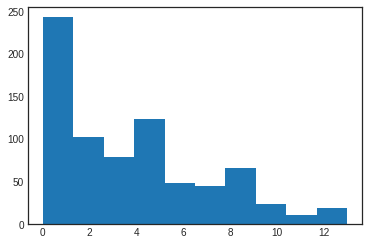

In [28]:
plt.hist(df["Pregnancies"])

# SKINTHICKNESS

Text(0.5, 0, 'Triceps skin fold thickness (mm) ')

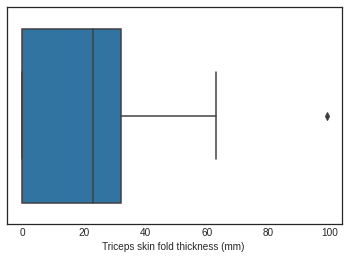

In [29]:
sns.boxplot(x=df["SkinThickness"])
plt.xlabel('Triceps skin fold thickness (mm) ')

In [30]:
outlier_skin=detect_outliers('SkinThickness')
df["SkinThickness"]=replace_outlier_with_median('SkinThickness',outlier_skin)

Text(0.5, 0, 'Triceps skin fold thickness (mm) ')

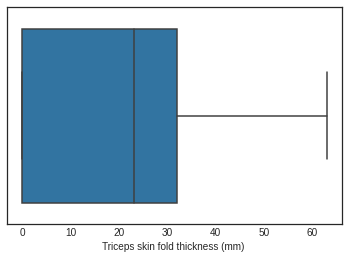

In [31]:
sns.boxplot(x=df["SkinThickness"])
plt.xlabel('Triceps skin fold thickness (mm) ')

(array([227.,  22.,  71., 106., 122., 102.,  77.,  28.,   6.,   2.]),
 array([ 0. ,  6.3, 12.6, 18.9, 25.2, 31.5, 37.8, 44.1, 50.4, 56.7, 63. ]),
 <a list of 10 Patch objects>)

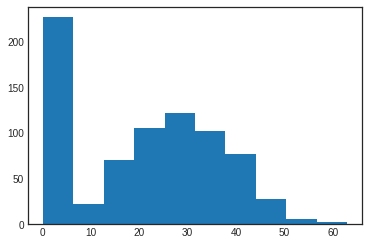

In [32]:
plt.hist(df["SkinThickness"])

In [33]:
df1=df[df["SkinThickness"]==0]
print(df1["SkinThickness"].value_counts())

0.0    227
Name: SkinThickness, dtype: int64


La presenza di 227 valori nulli è alquanto ingente, per questo ho deciso in questo caso di sostituirli con la mediana e di non dropparli.

In [34]:
df["SkinThickness"]=df["SkinThickness"].replace(0,df["SkinThickness"].median())

# BMI

Text(0.5, 0, 'Body mass index (weight in kg/(height in m)^2)  ')

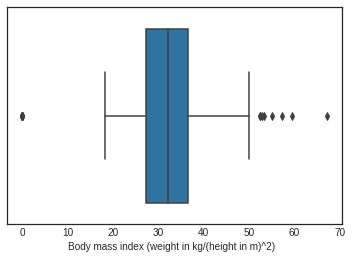

In [35]:
sns.boxplot(x=df["BMI"])
plt.xlabel('Body mass index (weight in kg/(height in m)^2)  ')

In [36]:
outlier_bmi=detect_outliers('BMI')
df["BMI"]=replace_outlier_with_median('BMI',outlier_bmi)

Text(0.5, 0, 'Body mass index (weight in kg/(height in m)^2)  ')

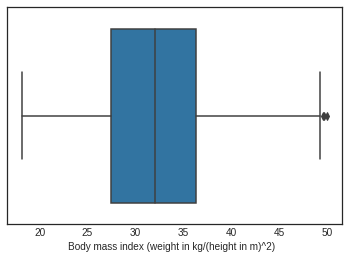

In [37]:
sns.boxplot(x=df["BMI"])
plt.xlabel('Body mass index (weight in kg/(height in m)^2)  ')

(array([ 26.,  67., 109., 128., 151., 121.,  76.,  49.,  28.,   8.]),
 array([18.2 , 21.38, 24.56, 27.74, 30.92, 34.1 , 37.28, 40.46, 43.64,
        46.82, 50.  ]),
 <a list of 10 Patch objects>)

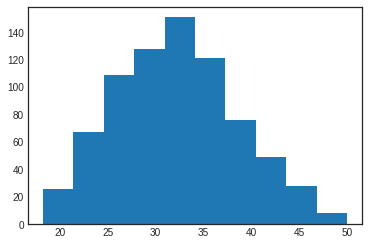

In [38]:
plt.hist(df["BMI"])

# Diabetes Pedigree Function

Diabetes Pedigree Function: Indica la funzione che valuta la probabilità di avere il diabete in base alla storia familiare

Text(0.5, 0, 'Diabetes pedigree function ')

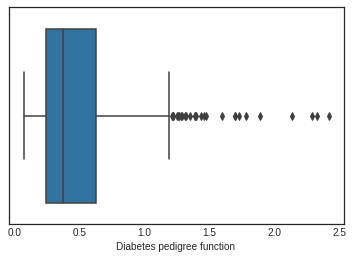

In [39]:
sns.boxplot(x=df["DiabetesPedigreeFunction"])
plt.xlabel('Diabetes pedigree function ')

In [40]:
outlier_diab=detect_outliers('DiabetesPedigreeFunction')
df["DiabetesPedigreeFunction"]=replace_outlier_with_median('DiabetesPedigreeFunction',outlier_diab)

Text(0.5, 0, 'Diabetes pedigree function ')

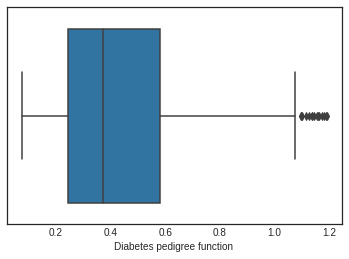

In [41]:
sns.boxplot(x=df["DiabetesPedigreeFunction"])
plt.xlabel('Diabetes pedigree function ')

(array([107., 196., 143.,  84.,  75.,  70.,  34.,  30.,   9.,  15.]),
 array([0.078 , 0.1893, 0.3006, 0.4119, 0.5232, 0.6345, 0.7458, 0.8571,
        0.9684, 1.0797, 1.191 ]),
 <a list of 10 Patch objects>)

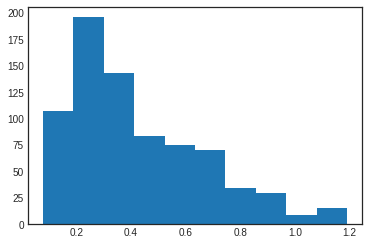

In [42]:
plt.hist(df["DiabetesPedigreeFunction"])

Rimpiazzo con il valore della media

In [43]:
df['DiabetesPedigreeFunction'].where(df['DiabetesPedigreeFunction'] > 1,df['DiabetesPedigreeFunction'].mean() , inplace=True)

# AGE

Text(0.5, 0, 'years ')

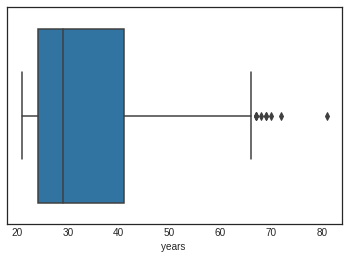

In [44]:
sns.boxplot(x=df["Age"])
plt.xlabel('years ')

In [45]:
outlier_age=detect_outliers('Age')
df["Age"]=replace_outlier_with_median('Age',outlier_age)

Text(0.5, 0, 'years ')

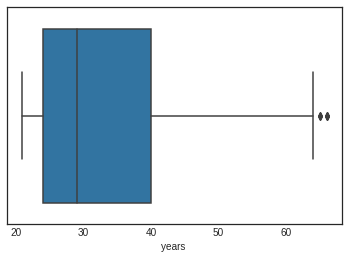

In [46]:
sns.boxplot(x=df["Age"])
plt.xlabel('years ')

(array([264., 138.,  92.,  60.,  77.,  42.,  34.,  18.,  22.,  16.]),
 array([21. , 25.5, 30. , 34.5, 39. , 43.5, 48. , 52.5, 57. , 61.5, 66. ]),
 <a list of 10 Patch objects>)

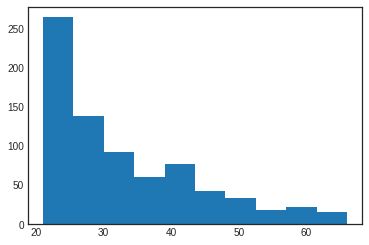

In [47]:
plt.hist(df["Age"])

Plottiamo l'outcome per vedere quante persone sono identificate come diabetiche nel dataset

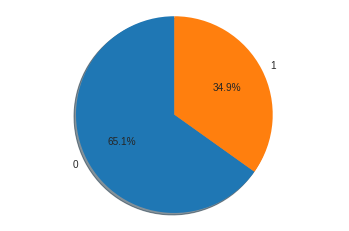

In [48]:
labels='0','1'
size0, size1 = df["Outcome"].value_counts()
sizes = [size0, size1]
explode = (0, 0)
fig1, ax1= plt.subplots()
ax1.pie(sizes,explode=explode,labels=labels,autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()


Dal risultato della computazione dell'outcome, il 65.1% di donne non è identificata come diabetica, mentre il 34.9% si

# Fairlearn

Ora bisogna andare ad identificare il mio protected attribute. Possiamo seguire due strade. La prima è creare una seconda colonna che codifichi l'eta come young,adult,old. La seconda invece è lasciare i valori numerici. Il mio scopo sarebbe capire se c'è una discriminazione verso candidati di una determinata categoria di età.
Bisognerebbe valutare se anche il BMI può essere identificato come un attributo protetto o meno. Per ora non lo considero come tale, poi vedo. 

Categorizziamo l'età come young e adult. In particolare se l'età è >25 sei considerato come adult

identifico come privileged value Adult, perchè secondo me è piu probabile che tu possa essere classificato come diabetico

Fatto la categorizzazione compute la distribuzione del protected attribute, e identifico come privileged value quella categoria di adulti. Perchè ? Perchè magari uno pensa che da adulti la probabilità di essere diabetico possa aumentare. 

In [49]:
def età(row):
    if(row["Age"]>25):
        return 'Adult'
    else:
        return 'Young'

In [50]:
df["AgeCategory"]=df.apply(lambda row: età(row), axis=1)

In [51]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeCategory
0,6.0,148,72.0,35.0,29.75,33.6,0.428035,50.0,1,Adult
1,1.0,85,66.0,29.0,29.75,26.6,0.428035,31.0,0,Adult
2,8.0,183,64.0,23.0,29.75,23.3,0.428035,32.0,1,Adult
3,1.0,89,66.0,23.0,94.00,28.1,0.428035,21.0,0,Young
4,0.0,137,40.0,35.0,168.00,43.1,0.428035,33.0,1,Adult


A questo punto rimpiazzo il valore 1 con Adult, e il valore 0 con Young

In [52]:
def visualize_att_dist(_data, _att, _category=False):
    plt.figure(figsize=[12,5], dpi=100)
    sns.set(style="darkgrid")  
    sns.set(font_scale = 1.5)
    if _category: # for categorical attribute
        vis_data = _data[_att].value_counts()
        ax = sns.barplot(x=vis_data.index, y=vis_data.values);
        ax.set_xlabel(_att)
        if len(vis_data) >= 5:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    else:
        ax = sns.distplot(_data[_att], kde=False, color='steelblue');
    ax.set_ylabel("Count")
    plt.tight_layout()

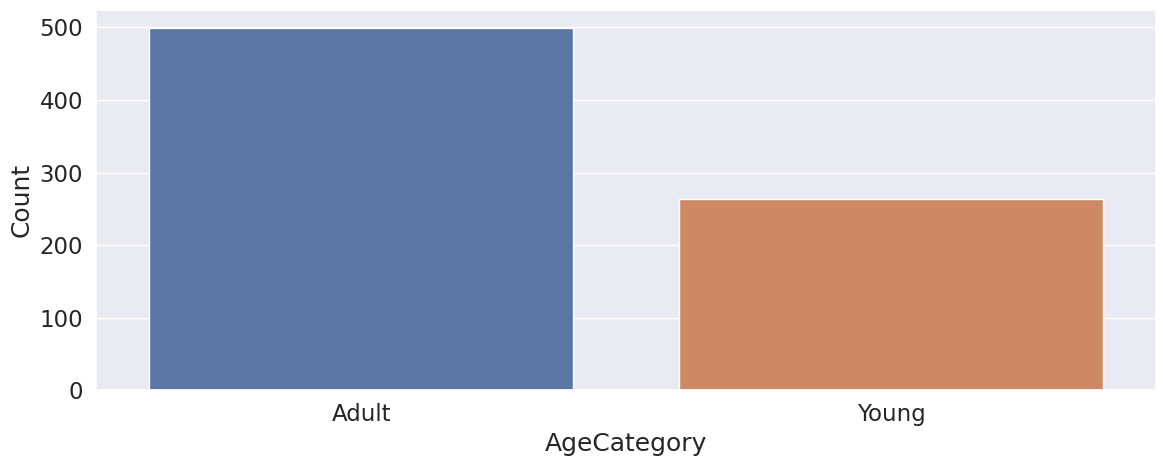

In [53]:
visualize_att_dist(df, "AgeCategory", _category=True)

In [54]:
df=df.replace({"Adult":1})

In [55]:
df=df.replace({"Young":0})

In [56]:
privileged_age=np.where(df["AgeCategory"]==1)[0]

In [57]:
df1=df.copy()

In [58]:
feature_cols=["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age","AgeCategory"]
X=df[feature_cols]
y=df["Outcome"]


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [60]:
classifier = DecisionTreeClassifier()
classifier=classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)

In [61]:
age=df["AgeCategory"]
df1=df.copy()
df1=df1.reset_index()
X_test_reset=X_test.reset_index()
X_list=list(X_test_reset["index"])
y_true=df["Outcome"].loc[X_list]
age=df["AgeCategory"].loc[X_list]

In [62]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)

In [63]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "true positive rate": recall_score,
    "selection rate": selection_rate,
    "count": count,
}

In [64]:
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=age
)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b90dbc2e0>,
      dtype=object)

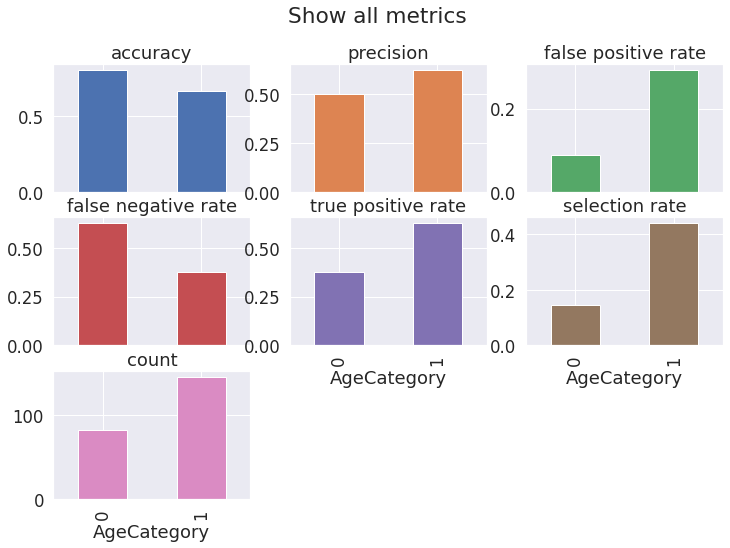

In [65]:
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)


TPR= P( Y=1 | y=1)[Adult] > P(Y=1|y=1)[Young]

FPR=P(Y=1|y=0)[Adult]>P(Y=1|y=0)[Young]

FNR=P(Y=0|y=1)[Young]>P(Y=1|y=0)[Adult]

SR= P(Y=1)

In [66]:
x=metric_frame.by_group
print(metric_frame.by_group)

             accuracy  precision  false positive rate  false negative rate  \
AgeCategory                                                                  
0            0.807229      0.500             0.089552                0.625   
1            0.671233      0.625             0.292683                0.375   

             true positive rate  selection rate  count  
AgeCategory                                             
0                         0.375        0.144578   83.0  
1                         0.625        0.438356  146.0  


In [67]:
dem_parity=demographic_parity_difference(y_true,y_pred,sensitive_features=age)
print(demographic_parity_difference(y_true,y_pred,sensitive_features=age))

0.29377785113054955


In [68]:
equalize_odds=equalized_odds_difference(y_true, y_pred, sensitive_features=age)
print(equalized_odds_difference(y_true, y_pred, sensitive_features=age))

0.25


In [69]:
x["true positive rate"]

AgeCategory
0    0.375
1    0.625
Name: true positive rate, dtype: float64

In [70]:
equal_opportunity=x["true positive rate"][1]-x["true positive rate"][0]
print("l'equal opportunity vale ",equal_opportunity)

l'equal opportunity vale  0.25


# **Mitigation**

For the mitigation i'll use the Correlation Remover algorithm.

A component that filters out sensitive correlations in a dataset.

CorrelationRemover applies a linear transformation to the non-sensitive feature columns in order to remove their correlation with the sensitive feature columns while retaining as much information as possible (as measured by the least-squares error).

In [71]:
from fairlearn.preprocessing import CorrelationRemover

In [72]:
cr = CorrelationRemover(sensitive_feature_ids=["AgeCategory"])

In [73]:
X_cr = cr.fit_transform(df)

In [74]:
cr_alpha = CorrelationRemover(sensitive_feature_ids=['AgeCategory'], alpha=0.5)

In [75]:
X_cr_alpha = cr_alpha.fit_transform(df)

In [76]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'AgeCategory'],
      dtype='object')

In [77]:
X_cr = pd.DataFrame(X_cr, columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'])

In [78]:
X_cr["AgeCategory"] = df["AgeCategory"]


In [79]:
X_cr_alpha = pd.DataFrame(X_cr_alpha, columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'])

In [80]:
X_cr_alpha["AgeCategory"] = df["AgeCategory"]

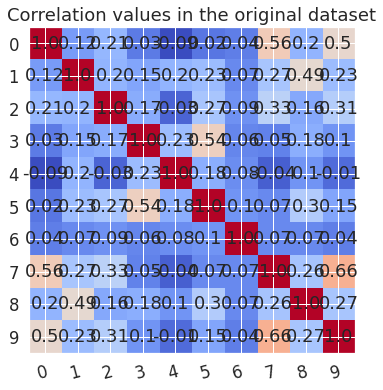

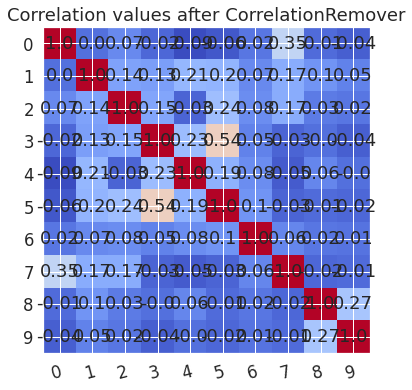

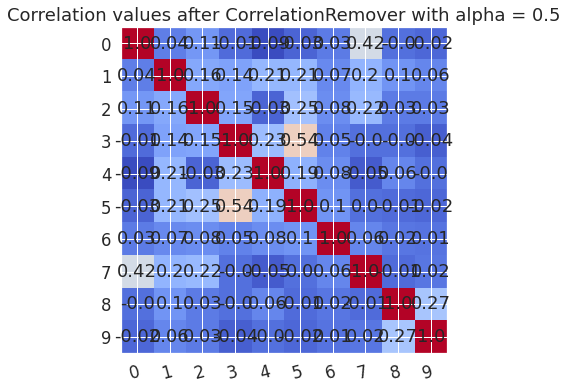

In [81]:
def plot_heatmap(df, title):
    df['Outcome'] = y
    cols = list(df.columns)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(round(df.corr(), 2), cmap="coolwarm")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(cols)))
    ax.set_yticks(np.arange(len(cols)))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(cols)):
        for j in range(len(cols)):
            ax.text(
                j,
                i,
                round(df.corr().to_numpy()[i, j], 2),
                ha="center",
                va="center",
            )

    ax.set_title(f"{title}")
    plt.show()


plot_heatmap(df, "Correlation values in the original dataset")
plot_heatmap(X_cr, "Correlation values after CorrelationRemover")
plot_heatmap(X_cr_alpha, "Correlation values after CorrelationRemover with alpha = 0.5")

# Metric Values after Correlation Remover


In [82]:
X_cr_alpha

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeCategory
0,5.407521,145.431558,70.761665,34.683238,30.091438,33.251156,0.426218,47.358770,1.0,1.0
1,0.407521,82.431558,64.761665,28.683238,30.091438,26.251156,0.426218,28.358770,0.0,1.0
2,7.407521,180.431558,62.761665,22.683238,30.091438,22.951156,0.426218,29.358770,1.0,1.0
3,2.119874,93.854745,68.340641,23.598728,93.354630,28.759369,0.431471,25.992325,0.0,0.0
4,-0.592479,134.431558,38.761665,34.683238,168.341438,42.751156,0.426218,30.358770,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
758,9.407521,98.431558,74.761665,47.683238,180.341438,32.551156,0.426218,60.358770,0.0,1.0
759,1.407521,119.431558,68.761665,26.683238,30.091438,36.451156,0.426218,24.358770,1.0,1.0
760,4.407521,118.431558,70.761665,22.683238,112.341438,25.851156,0.426218,27.358770,0.0,0.0
761,0.407521,123.431558,58.761665,22.683238,30.091438,29.751156,0.426218,44.358770,1.0,1.0


In [83]:
X=X_cr_alpha[feature_cols]
y=X_cr_alpha["Outcome"]

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [85]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaledXtrain = scaler.fit_transform(X_train)
scaledXtest = scaler.fit_transform(X_test)
scaled_Xtrain = pd.DataFrame(scaledXtrain, columns=X_train.columns)
scaled_Xtest = pd.DataFrame(scaledXtrain, columns=X_train.columns)

In [86]:
scaled_Xtrain

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,AgeCategory
0,0.384615,0.270897,0.588235,0.404108,0.054877,0.298413,0.000000,0.275000,1.0
1,0.692308,0.621832,0.617647,0.685226,0.383580,0.625397,0.000000,0.350000,1.0
2,0.384615,0.634146,0.588235,0.281119,0.054877,0.492063,0.000000,0.975000,1.0
3,0.538462,0.430973,0.558824,0.175699,0.318003,0.177778,0.000000,0.125000,1.0
4,0.285566,0.273503,0.552632,0.156644,0.203287,0.409785,0.006885,0.165839,1.0
...,...,...,...,...,...,...,...,...,...
529,0.208643,0.335070,0.287926,0.332343,0.281979,0.254229,0.006885,0.115839,1.0
530,0.307692,0.240114,0.705882,0.210839,0.054877,0.352381,0.000000,0.200000,1.0
531,1.000000,0.504854,0.764706,0.281119,0.054877,0.800000,0.000000,0.400000,1.0
532,0.131719,0.876865,0.817338,0.367483,0.051642,0.854229,0.006885,0.115839,1.0


In [87]:
np.isnan(scaled_Xtrain).sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
AgeCategory                 3
dtype: int64

In [88]:
scaled_Xtrain["AgeCategory"] = scaled_Xtrain["AgeCategory"].fillna(0)


In [89]:
np.isnan(scaled_Xtrain).sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
AgeCategory                 0
dtype: int64

In [90]:
np.isnan(scaled_Xtest).sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
AgeCategory                 0
dtype: int64

In [91]:
np.isnan(y_train).sum()

3

In [92]:
type(y_train)

pandas.core.series.Series

In [93]:
y_train = y_train.fillna(0)

In [94]:
classifier = DecisionTreeClassifier()
classifier=classifier.fit(scaled_Xtrain,y_train)
y_pred = classifier.predict(scaled_Xtest)

In [95]:
X_cr_alpha["AgeCategory"] = X_cr_alpha["AgeCategory"].fillna(0)

In [96]:
age=X_cr_alpha["AgeCategory"]
df2=X_cr_alpha.copy()
df2=df2.reset_index()
X_test_reset=scaled_Xtest.reset_index()
X_list=list(X_test_reset["index"])
y_true=X_cr_alpha["Outcome"].loc[X_list]
age=X_cr_alpha["AgeCategory"].loc[X_list]

In [97]:
print(type(y_true))
print(type(y_pred))
print(len(y_true))
print(len(y_pred))
print(type(age))
y_true = y_true.fillna(0)

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
534
534
<class 'pandas.core.series.Series'>


In [98]:
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=age
)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b8f050880>,
      dtype=object)

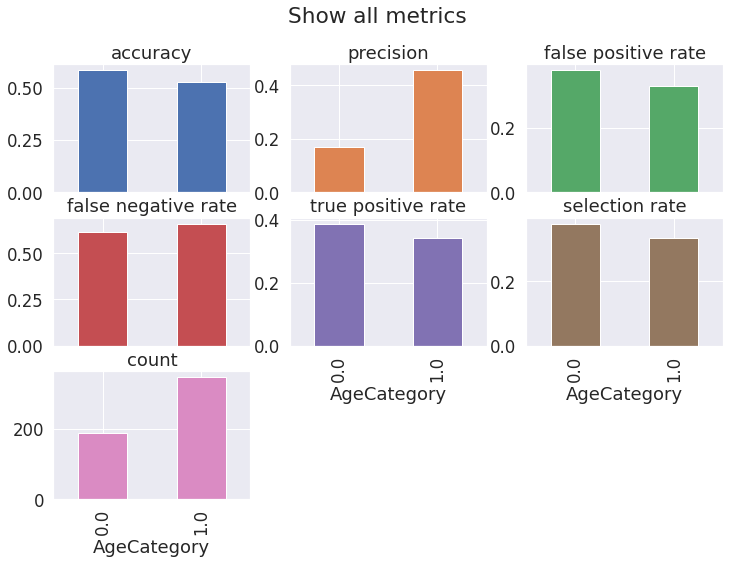

In [99]:
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [100]:
dem_parity=demographic_parity_difference(y_true,y_pred,sensitive_features=age)
print(demographic_parity_difference(y_true,y_pred,sensitive_features=age))

0.045385196258225624


In [101]:
equalize_odds=equalized_odds_difference(y_true, y_pred, sensitive_features=age)
print(equalized_odds_difference(y_true, y_pred, sensitive_features=age))

0.050080128205128194


In [102]:
x1=metric_frame.by_group
print(metric_frame.by_group)

             accuracy  precision  false positive rate  false negative rate  \
AgeCategory                                                                  
0.0          0.582888   0.169014             0.378205             0.612903   
1.0          0.524496   0.456897             0.328125             0.658065   

             true positive rate  selection rate  count  
AgeCategory                                             
0.0                    0.387097        0.379679  187.0  
1.0                    0.341935        0.334294  347.0  


In [103]:
x1["true positive rate"]

AgeCategory
0.0    0.387097
1.0    0.341935
Name: true positive rate, dtype: float64

In [104]:
equal_opportunity=x1["true positive rate"][1]-x1["true positive rate"][0]
print("l'equal opportunity vale ",equal_opportunity)

l'equal opportunity vale  -0.04516129032258065
